# TGDS Residual Learning

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.lstm_residual_model as lstm
import src.models.thevenin_model as thevenin

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [2]:
HYPER_PARAMS =  np.load('../../../models/TGDS/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 1,       # number of input features
    'd_t': 0.25,           # current integration factor
    'num_repeat': 10,      # repetition factor for each training profile to create more auxiliary data
    'theory_model': 2228,  # the unique thevenin model ID for which the parameters have been computed
}

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [3]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
# training_sets = TRAINING_SETS['10A_all'] + TRAINING_SETS['-10A_all'] + TRAINING_SETS['25A_all'] + TRAINING_SETS['-25A_all']
training_sets = TRAINING_SETS['10A_all']

train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]]

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
X_train, y_train, u_train, scalers_train = util.prepare_residual_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_validation, y_validation, u_validation, _ = util.prepare_residual_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_test, y_test, u_test, _ = util.prepare_residual_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (93500, 100, 1)  Output/Label: (93500, 1)
Input: (1500, 100, 1)  Output/Label: (1500, 1)
Input: (1650, 100, 1)  Output/Label: (1650, 1)


### Initialize and Train Model

In [4]:
lstm = lstm.Residual_Model()
lstm.initialize(HYPER_PARAMS)

Model: "Residual_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
2922/2922 [==============================] - 394s 135ms/step - loss: 2.2684e-04 - mse: 2.2684e-04 - mae: 0.0113
Epoch 2/5
2922/2922 [==============================] - 391s 134ms/step - loss: 2.2560e-04 - mse: 2.2560e-04 - mae: 0.0112
Epoch 3/5
2922/2922 [==============================] - 391s 134ms/step - loss: 2.2512e-04 - mse: 2.2512e-04 - mae: 0.0112
Epoch 4/5
2922/2922 [==============================] - 390s 133ms/step - loss: 2.2476e-04 - mse: 2.2476e-04 - mae: 0.0112
Epoch 5/5
2922/2922 [==============================] - 389s 133ms/step - loss: 2.2459e-04 - mse: 2.2459e-04 - mae: 0.0112
Training time: 1956.552s


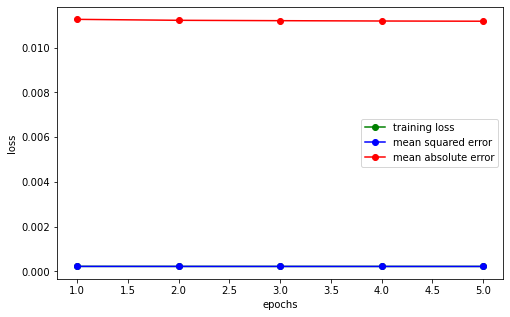

INFO:tensorflow:Assets written to: ../../../models/TGDS/2329\assets


In [5]:
_, fig = lstm.train(HYPER_PARAMS, X_train, y_train, scalers_train)

# save model, hyperparameters and plots
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/theory_guided_residual-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A Run 040618']
2922/2922 [==============================] - 164s 56ms/step
Prediction time on Training Set:  163.774s
47/47 [==============================] - 3s 55ms/step
Prediction time on Validation Set:  2.629s
52/52 [==============================] - 3s 55ms/step
Prediction time on Test Set:  2.93s
###########################################################
            Training    Validation     Test
--------  ----------  ------------  -------
MSE (μV)     25.8           9       13.8
MAE (V)       0.0038        0.0026   0.0035
MaxE (V)      0.0144        0.0051   0.0069
###########################################################


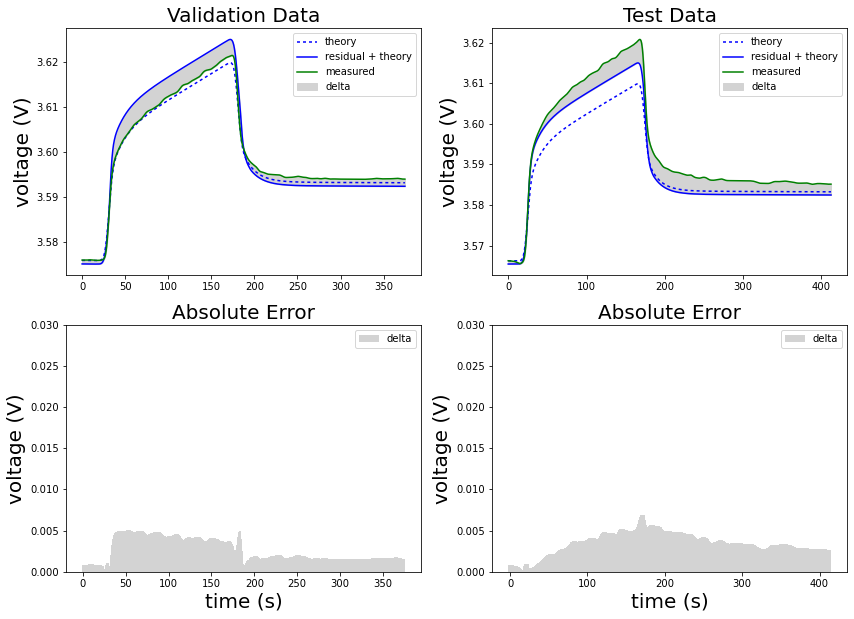

In [6]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_plus_uhat_val_unscaled, fig = lstm.test(X_train, y_train, u_train, X_validation, y_validation, u_validation, X_test, y_test, u_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_plus_uhat_val_unscaled)
fig.savefig('../../../reports/figures/theory_guided_residual-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [7]:
TEST_SETS =  np.load('../../../models/TGDS/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

X_case_1, y_case_1, u_case_1, _ = util.prepare_residual_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, u_case_2, _ = util.prepare_residual_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, u_case_3, _ = util.prepare_residual_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 1)  Output/Label: (1500, 1)
Input: (3100, 100, 1)  Output/Label: (3100, 1)
Input: (1600, 100, 1)  Output/Label: (1600, 1)


Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
2922/2922 [==============================] - 162s 55ms/step
Prediction time on Training Set:  162.155s
47/47 [==============================] - 3s 54ms/step
Prediction time on Use Case 1:  2.607s
97/97 [==============================] - 5s 55ms/step
Prediction time on Use Case 2:  5.4s
50/50 [==============================] - 3s 54ms/step
Prediction time on Use Case 3:  2.779s
##############################################################
            Training    Use Case 1    Use Case 2    Use Case 3
--------  ----------  ------------  ------------  ------------
MSE (μV)     25.8           9            11.9          43.4
MAE (V)       0.0038        0.0026        0.0026        0.0062
MaxE (V)      0.0144        0.0051        0.0102        0.0095
##############################################################


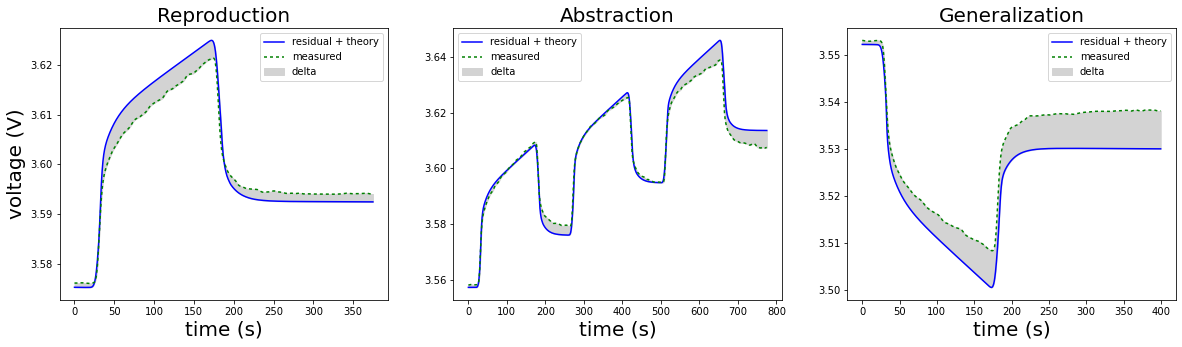

In [8]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

fig = lstm.test_usecases(X_train, y_train, u_train, X_case_1, y_case_1, u_case_1, X_case_2, y_case_2, u_case_2, X_case_3, y_case_3, u_case_3, scalers_train)